# Chapter 8.5: Spider-Man

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [1]:
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

def angle_to_components(mag,angle):
    theta = np.deg2rad(angle)
    x = mag * np.cos(theta)
    y = mag * np.sin(theta)
    return pd.Series(dict(x=x,y=y),dtype=float)

Downloaded ModSimPy_Functions/modsim.py


In this case study we'll develop a model of Spider-Man swinging from a springy cable of webbing attached to the top of the Empire State Building.  Initially, Spider-Man is at the top of a nearby building, as shown in this diagram.

![Diagram of the initial state for the Spider-Man case
study.](https://github.com/AllenDowney/ModSim/raw/main/figs/spiderman.png)

The origin, `O`, is at the base of the Empire State Building.  The vector `H` represents the position where the webbing is attached to the building, relative to `O`.  The vector `P` is the position of Spider-Man relative to `O`.  And `L` is the vector from the attachment point to Spider-Man.

By following the arrows from `O`, along `H`, and along `L`, we can see that 

`H + L = P`

So we can compute `L` like this:

`L = P - H`

The goals of this case study are:

1. Implement a model of this scenario to predict Spider-Man's trajectory.

2. Choose the right time for Spider-Man to let go of the webbing in order to maximize the distance he travels before landing.

I'll create a `params` object to contain the quantities we'll need:

1. According to [the Spider-Man Wiki](http://spiderman.wikia.com/wiki/Peter_Parker_%28Earth-616%29), Spider-Man weighs 76 kg.

2. Let's assume his terminal velocity is 60 m/s.

3. The length of the web is 100 m.

4. The initial angle of the web is 45 degrees passed the horizontal.

5. The spring constant of the web is 40 N / m when the cord is stretched, and 0 when it's compressed.

Here's a `params` object with the parameters of the system.

In [ ]:
params = dict(height = 381,    # m,
                g = 9.8,         # m/s**2,
                mass = 75,       # kg,
                area = 1,        # m**2,
                rho = 1.2,       # kg/m**3,
                v_term = 60,     # m / s,
                length = 100,          # m,
                angle = (180 + 45),    # degree, 
                                       # using the traditional +x axis as 0 degrees
                k = 40,                # N / m,
                t_0 = 0,               # s,
                t_end = 200,             # s
              t_release = 9)           # s

Compute the initial position

In [ ]:
def initial_condition(params):
    """Compute the initial position and velocity.
    
    params: Params object
    """
    # Define the H vector
    H_vec = pd.Series(dict(x=0, y=params['height']),dtype = float)
    
    # Convert the polar coordinates to cartesian coordinates
    # for position
    x, y = angle_to_components(params['length'], params['angle'])
    L_vec = pd.Series(dict(x = x, y = y), dtype=float)
    P_vec = H_vec + L_vec
    
    return pd.Series(dict(x=P_vec.x, y=P_vec.y, vx=0, vy=0))

In [ ]:
initial_condition(params)

x     -70.710678
y     310.289322
vx      0.000000
vy      0.000000
dtype: float64

Now here's a version of `make_system` that takes a `params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [ ]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    init = initial_condition(params)
    height, g, mass, area, rho, v_term, length, angle, k, t_0, t_end, t_release = params.values()
    
    C_d = (2 * mass * g) / (rho * area * v_term**2)
    
    return dict(height=height, mass=mass, g=g, rho=rho, area=area,
                  v_term=v_term, length=length, angle=angle,
                k=k, t_0=t_0, t_end=t_end, init=init, C_d=C_d, t_release=t_release)

Let's make a `system`

In [ ]:
system = make_system(params)

In [ ]:
system['init']

x     -70.710678
y     310.289322
vx      0.000000
vy      0.000000
dtype: float64

### Drag and spring forces

Here's drag force, as we saw in Chapter 8.1.

In [ ]:
def drag_force(V_vec, system):
    """Compute drag force.
    
    V⃗: velocity Vector
    system: `System` object
    
    returns: force Vector
    """
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    v_mag = np.sqrt(V_vec.x**2 + V_vec.y**2)
    d_mag = rho * v_mag**2 * C_d * area / 2
    if v_mag != 0:
        direction = -V_vec/v_mag
    else:
        direction = pd.Series(dict(x = 0, y = 0), dtype = float)
    f_drag = direction * d_mag
    return f_drag

In [ ]:
V_vec_test = pd.Series(dict(x=10, y=10), dtype = float)

In [ ]:
drag_force(V_vec_test, system)

x   -28.873527
y   -28.873527
dtype: float64

And here's the 2-D version of spring force.  We saw the 1-D version in Chapter 21.

In [ ]:
def spring_force(t, L_vec, system):
    """Compute drag force.
    
    L_vec: Vector representing the webbing
    system: System object
    
    returns: force Vector
    """
    t_release = system['t_release']
    if t < t_release:
        L_mag = np.sqrt(L_vec.x**2 + L_vec.y**2)
        extension = L_mag - system['length']
        if extension < 0:
            s_mag = 0
        else:
            s_mag = system['k'] * extension
        direction = -L_vec/L_mag
        f_spring = direction * s_mag
    else: 
        f_spring = 0
    return f_spring

In [ ]:
L_test = pd.Series(dict(x = 0, y = -system['length']-1), dtype = float)

In [ ]:
f_spring = spring_force(0, L_test, system)
f_spring

x    -0.0
y    40.0
dtype: float64

Here's the slope function, including acceleration due to gravity, drag, and the spring force of the webbing.

In [ ]:
def slope_func(t, state, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    P_vec = pd.Series(dict(x = x, y = y), dtype = float)
    V_vec = pd.Series(dict(x = vx, y = vy), dtype = float)
    g, mass = system['g'], system['mass']
    
    H_vec = pd.Series(dict(x = 0, y = system['height']), dtype = float)
    L_vec = P_vec - H_vec
    
    a_grav = pd.Series(dict(x = 0, y = -g), dtype = float)
    a_spring = spring_force(t, L_vec, system) / mass
    a_drag = drag_force(V_vec, system) / mass
    
    A_vec = a_grav + a_drag + a_spring
    
    return V_vec.x, V_vec.y, A_vec.x, A_vec.y

As always, let's test the slope function with the initial conditions.

In [ ]:
slope_func(0, system['init'], system)

(0.0, 0.0, 5.359248925640619e-15, -9.799999999999995)

Here's an event function that stops the simulation when Spider-Man reaches the ground.

In [ ]:
def event_func(t, state, system):
    """Stops when y=0.
    
    state: State object
    t: time
    system: System object
    
    returns: height
    """
    x, y, vx, vy = state
    return y

And then run the simulation.

In [ ]:
results, details = run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

### Visualizing the results

We can extract the x and y components as `Series` objects.

The simplest way to visualize the results is to plot x and y as functions of time.

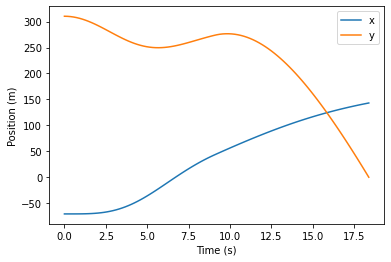

In [ ]:
def plot_position(results):
    results.x.plot(label='x',legend=True)
    results.y.plot(label='y', xlabel='Time (s)',
             ylabel='Position (m)', legend=True)
    
plot_position(results)

We can plot the velocities the same way.

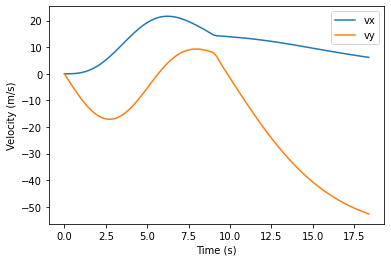

In [ ]:
def plot_velocity(results):
    results.vx.plot(label='vx', legend=True)
    results.vy.plot(label='vy',xlabel='Time (s)',
             ylabel='Velocity (m/s)',legend=True)
    
plot_velocity(results)

Neither of these is a very satisfactory way of understanding the motion.  A better way to visualize the results is to plot y versus x.  The result is the trajectory through the 2D plane of motion.

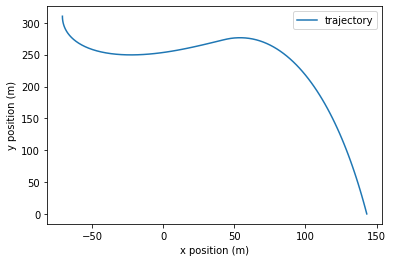

In [ ]:
def plot_trajectory(results, label):
    x = results.x.values
    y = results.y.values
    traj = pd.Series(data=y, index=x)
    traj.plot(label=label, xlabel='x position (m)',
             ylabel='y position (m)',legend=True)
    
plot_trajectory(results, label='trajectory')

And here's a test run.

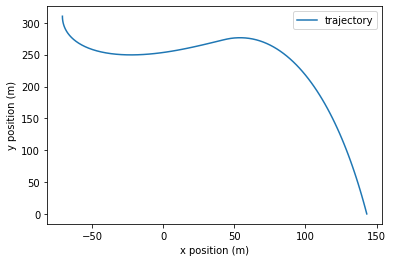

In [ ]:
params1 = params.copy()
params1.update(dict(t_release = 9))
system1 = make_system(params1)
results, details = run_solve_ivp(system1, slope_func, events=event_func)
details.message
plot_trajectory(results, 'trajectory')

In [ ]:
x_final = results.iloc[-1].x
x_final

143.4532612857731

## Maximizing range

To find the best value of `t_release`, we need a function that takes possible values, runs the simulation, and returns the negative of the range value (so we can minimize this function later).

In [ ]:
def range_func(t_release, params):
    """Compute the final value of x.
    
    t_release: time to release web
    params: Params object
    """
    params1 = params.copy()
    params1.update(dict(t_release = t_release))
    system1 = make_system(params1)
    results, details = run_solve_ivp(system1, slope_func, events=event_func)
    x_final = results.iloc[-1].x
    print("release time:", t_release, "     x position at landing:", round(x_final,2))
    return -x_final

We can test it.

In [ ]:
range_func(9, params)

release time: 9      x position at landing: 143.09


-143.09237104119367

And run it for a few values.

In [ ]:
for t_release in np.arange(3, 18, 3):
    range_func(t_release, params)

release time: 3      x position at landing: -27.57
release time: 6      x position at landing: 116.4
release time: 9      x position at landing: 143.09
release time: 12      x position at landing: 75.19
release time: 15      x position at landing: -25.13


Now we can use `maximize_scalar` to find the optimum.

In [ ]:
bounds = [6, 12]
spo.minimize_scalar(range_func, args=params, method='bounded',bounds = bounds)
res = minimize_scalar(range_func, params, bounds=bounds)

release time: 8.29179606750063      x position at landing: 148.89
release time: 9.70820393249937      x position at landing: 133.92
release time: 7.416407864998738      x position at landing: 147.5
release time: 8.003744560172075      x position at landing: 149.51
release time: 7.97833864710431      x position at landing: 149.51
release time: 7.991041603638193      x position at landing: 149.51
release time: 7.986189505999862      x position at landing: 149.51
release time: 7.9831907447426405      x position at landing: 149.51
release time: 7.981337408361531      x position at landing: 149.51
release time: 7.980191983485419      x position at landing: 149.51
release time: 7.979484071980422      x position at landing: 149.51
release time: 7.979046558609307      x position at landing: 149.51
release time: 7.978776160475425      x position at landing: 149.51
release time: 7.9786090452381915      x position at landing: 149.51
release time: 7.978505762341543      x position at landing: 149.

Finally, we can run the simulation with the optimal value.

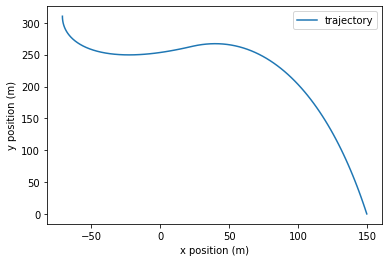

In [ ]:
best_time = res.x
params1 = params.copy()
params1.update(dict(t_release = best_time))
system1 = make_system(params1)
results, details = run_solve_ivp(system1, slope_func, events=event_func)
plot_trajectory(results, label='trajectory')

In [ ]:
x_final = results.iloc[-1].x
x_final

149.50975689977673